Используйте готовый ноутбук с занятия.

Соберите обучающую и проверочную выборку (просто запуская последовательно ячейки ноутбука).
Обучите полносвязную сеть.
Сделайте совсем простую сеть: один скрытый слой и 10 нейронов.
Сделайте сложную сеть: 5-7 слоёв по 100-1000 нейронов.
Добавьте в сеть слои Dropout.
Добавьте в сеть слои BatchNormalization.
Поменяйте внутренние активационные функции, варианты: relu, elu, linear.
Поменяйте размер batch_size: маленький, средний и большой.
Во всех пунктах, где запускали сеть (пункты 2-8), напишите, какую использовали архитектуру, какая была точность на обучающей и проверочной выборках.

Напишите свои выводы.

# Импорт библиотек

In [ ]:
from google.colab import files, drive
from tensorflow.keras.utils import to_categorical
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Подключение к Диску и импорт данных

In [ ]:
drive.mount('/content/drive')
!unzip -q '/content/drive/MyDrive/Lessons/Lesson8/genres.zip'
genres = os.listdir('genres')
!ls genres 
!ls genres/blues

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blue

# Функции для работы с аудиозаписями

In [ ]:
def get_features(y, sr):
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  mfcc = librosa.feature.mfcc(y=y, sr=sr)
  
  rmse = np.mean(librosa.feature.rms(y=y))
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
  zcr = np.mean(librosa.feature.zero_crossing_rate(y))
  
  out = []
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)

  for e in mfcc:
    out.append(np.mean(e))

  for e in chroma_stft:
    out.append(np.mean(e))
  
  return out

 # Подготовка данных для обучения

In [ ]:
import time

X_train = []
Y_train = []

curr_time = time.time()

for i in range(len(genres)):
  g = genres[i]
  for filename in os.listdir(f'./genres/{g}'):
    songname = f'./genres/{g}/{filename}'
    y, sr = librosa.load(songname, mono=True, duration=30)
    out = get_features(y, sr)
    
    X_train.append(out)
    Y_train.append(to_categorical(i, len(genres)))

  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр jazz готов -> 45c
Жанр pop готов -> 42c
Жанр reggae готов -> 42c
Жанр country готов -> 42c
Жанр metal готов -> 42c
Жанр hiphop готов -> 42c
Жанр disco готов -> 42c
Жанр classical готов -> 42c
Жанр blues готов -> 42c
Жанр rock готов -> 42c


In [ ]:
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [ ]:
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 37)
(1000, 10)
(1000,)


## Стандартизация

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
print(X_train[0])

[-0.80372579 -1.1514786  -0.8917118  -1.26292775 -1.0004115  -1.03431808
  0.84399098 -0.16866289 -0.36123783  0.00561706 -1.42372136  0.71159049
 -0.94424594  1.17114096 -1.53071951 -0.0648977  -1.63492293  0.13035587
  0.10977987  0.86579415 -1.13823083  0.5396549  -1.04463061 -1.03114786
 -1.63136459 -0.29114808 -0.41356522 -1.11907565 -1.10894143 -2.09337072
 -1.97141078 -2.0367719  -1.58694981 -1.18159244 -1.57842715 -0.19586685
 -1.34449679]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 37)
(900,)
(100, 37)
(100,)


# Список точностей моделей

In [ ]:
modelsTrainAccuracy = list()
modelsTestAccuracy = list()

# Подготовка и обучение модели. Эксперименты

## Функция создания модели

In [ ]:
def model_create_learn(neurons=200, nn=False, levels=4, activ="elu", dropout=0, bn=0, batch=20):
  indexes = range(0,37)

  model = Sequential()
  for ii in range(levels):
    if bn:
      model.add(BatchNormalization())
      bn -= 1
    if dropout:
      model.add(Dropout(0.2))
      dropout -= 1
  
    model.add(Dense(neurons, activation=activ, input_shape=(len(indexes),)))
    if nn:
      neurons /= 2

  model.add(Dense(len(genres), activation='softmax'))

  model.compile(optimizer=RMSprop(lr=1e-4),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  history = model.fit(X_train[:, indexes],
                      y_train,
                      epochs=200,
                      batch_size=batch,
                      validation_data=(X_test[:, indexes], y_test))

  plt.plot(history.history["accuracy"])
  plt.plot(history.history["val_accuracy"])
  plt.show()

  del model
  
  return history

## Полносвязная модель (Э. 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
45/45 [==============================] - 1s 6ms/step - loss: 1.9753 - accuracy: 0.3044 - val_loss: 1.8266 - val_accuracy: 0.3000
Epoch 2/200
45/45 [==============================] - 0s 2ms/step - loss: 1.6568 - accuracy: 0.4044 - val_loss: 1.6741 - val_accuracy: 0.3200
Epoch 3/200
45/45 [==============================] - 0s 2ms/step - loss: 1.5165 - accuracy: 0.4444 - val_loss: 1.5812 - val_accuracy: 0.3600
Epoch 4/200
45/45 [==============================] - 0s 2ms/step - loss: 1.4227 - accuracy: 0.5011 - val_loss: 1.5279 - val_accuracy: 0.3700
Epoch 5/200
45/45 [==============================] - 0s 2ms/step - loss: 1.3532 - accuracy: 0.5289 - val_loss: 1.4838 - val_accuracy: 0.4200
Epoch 6/200
45/45 [==============================] - 0s 2ms/step - loss: 1.2957 - accuracy: 0.5522 - val_loss: 1.4514 - val_accuracy: 0.3900
Epoch 7/200
45/45 [==============================] - 0s 2ms/step - loss: 1.2437 - accuracy: 0.5789 - val_loss: 1.4181 - val_accuracy: 0.4300
Epoch 8/200
4

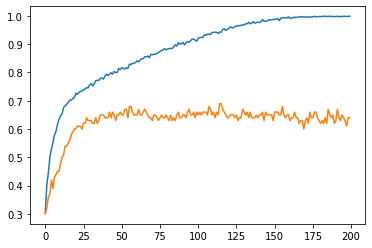

In [ ]:
history = model_create_learn(neurons=256, nn=True)

modelsTrainAccuracy.append(history.history["accuracy"][-1])
modelsTestAccuracy.append(history.history["val_accuracy"][-1])

del history

## Простая модель: один скрытый слой и 10 нейронов (Э. 2)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
45/45 [==============================] - 1s 4ms/step - loss: 2.2750 - accuracy: 0.1500 - val_loss: 2.0455 - val_accuracy: 0.2700
Epoch 2/200
45/45 [==============================] - 0s 2ms/step - loss: 1.9938 - accuracy: 0.3144 - val_loss: 1.8553 - val_accuracy: 0.3800
Epoch 3/200
45/45 [==============================] - 0s 1ms/step - loss: 1.8206 - accuracy: 0.3844 - val_loss: 1.7356 - val_accuracy: 0.3700
Epoch 4/200
45/45 [==============================] - 0s 1ms/step - loss: 1.7062 - accuracy: 0.3900 - val_loss: 1.6557 - val_accuracy: 0.3700
Epoch 5/200
45/45 [==============================] - 0s 1ms/step - loss: 1.6258 - accuracy: 0.4156 - val_loss: 1.5988 - val_accuracy: 0.3800
Epoch 6/200
45/45 [==============================] - 0s 2ms/step - loss: 1.5637 - accuracy: 0.4311 - val_loss: 1.5511 - val_accuracy: 0.4100
Epoch 7/200
45/45 [==============================] - 0s 2ms/step - loss: 1.5123 - accuracy: 0.4500 - val_loss: 1.5133 - val_accuracy: 0.4500
Epoch 8/200
4

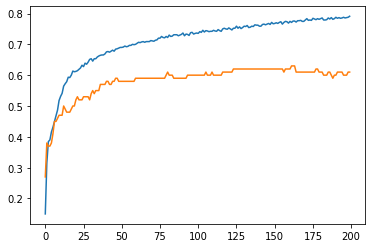

In [ ]:
history = model_create_learn(levels=1)

modelsTrainAccuracy.append(history.history["accuracy"][-1])
modelsTestAccuracy.append(history.history["val_accuracy"][-1])

del history

## Сложная модель: 5-7 слоёв по 100-1000 нейронов (Э. 3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
45/45 [==============================] - 1s 8ms/step - loss: 1.7799 - accuracy: 0.3467 - val_loss: 1.5812 - val_accuracy: 0.3600
Epoch 2/200
45/45 [==============================] - 0s 4ms/step - loss: 1.4201 - accuracy: 0.4900 - val_loss: 1.4332 - val_accuracy: 0.4400
Epoch 3/200
45/45 [==============================] - 0s 4ms/step - loss: 1.2695 - accuracy: 0.5633 - val_loss: 1.3584 - val_accuracy: 0.4300
Epoch 4/200
45/45 [==============================] - 0s 4ms/step - loss: 1.1649 - accuracy: 0.5978 - val_loss: 1.3222 - val_accuracy: 0.4800
Epoch 5/200
45/45 [==============================] - 0s 4ms/step - loss: 1.0881 - accuracy: 0.6322 - val_loss: 1.2737 - val_accuracy: 0.4700
Epoch 6/200
45/45 [==============================] - 0s 4ms/step - loss: 1.0248 - accuracy: 0.6689 - val_loss: 1.2313 - val_accuracy: 0.4900
Epoch 7/200
45/45 [==============================] - 0s 4ms/step - loss: 0.9764 - accuracy: 0.6678 - val_loss: 1.2384 - val_accuracy: 0.4900
Epoch 8/200
4

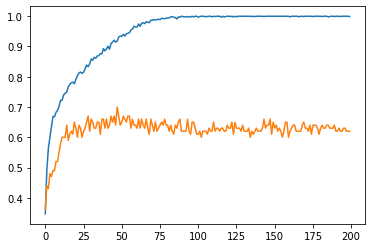

In [ ]:
history = model_create_learn(levels=6, neurons=200)

modelsTrainAccuracy.append(history.history["accuracy"][-1])
modelsTestAccuracy.append(history.history["val_accuracy"][-1])

del history

## Модель со слоем Dropout (Э. 4)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
45/45 [==============================] - 1s 6ms/step - loss: 1.9029 - accuracy: 0.3156 - val_loss: 1.7270 - val_accuracy: 0.2900
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 1.6136 - accuracy: 0.4200 - val_loss: 1.5859 - val_accuracy: 0.3200
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 1.4979 - accuracy: 0.4600 - val_loss: 1.4949 - val_accuracy: 0.4000
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 1.4324 - accuracy: 0.4744 - val_loss: 1.4432 - val_accuracy: 0.4000
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 1.3797 - accuracy: 0.5178 - val_loss: 1.4026 - val_accuracy: 0.4200
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 1.3211 - accuracy: 0.5400 - val_loss: 1.3702 - val_accuracy: 0.4400
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 1.3101 - accuracy: 0.5378 - val_loss: 1.3484 - val_accuracy: 0.4500
Epoch 8/200
4

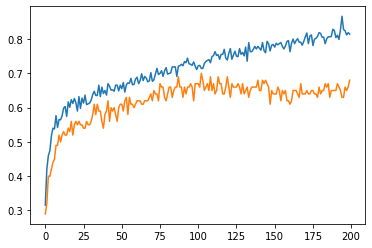

In [ ]:
history = model_create_learn(dropout=2)

modelsTrainAccuracy.append(history.history["accuracy"][-1])
modelsTestAccuracy.append(history.history["val_accuracy"][-1])

del history

## Модель со слоем BatchNormalization (Э. 5)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
45/45 [==============================] - 2s 7ms/step - loss: 1.9350 - accuracy: 0.3122 - val_loss: 1.7448 - val_accuracy: 0.3900
Epoch 2/200
45/45 [==============================] - 0s 4ms/step - loss: 1.4769 - accuracy: 0.4778 - val_loss: 1.5401 - val_accuracy: 0.5300
Epoch 3/200
45/45 [==============================] - 0s 4ms/step - loss: 1.2860 - accuracy: 0.5733 - val_loss: 1.3791 - val_accuracy: 0.4900
Epoch 4/200
45/45 [==============================] - 0s 4ms/step - loss: 1.1768 - accuracy: 0.5989 - val_loss: 1.2827 - val_accuracy: 0.5200
Epoch 5/200
45/45 [==============================] - 0s 4ms/step - loss: 1.1188 - accuracy: 0.6300 - val_loss: 1.2224 - val_accuracy: 0.5100
Epoch 6/200
45/45 [==============================] - 0s 4ms/step - loss: 1.0876 - accuracy: 0.6322 - val_loss: 1.1801 - val_accuracy: 0.5400
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 1.0411 - accuracy: 0.6356 - val_loss: 1.1387 - val_accuracy: 0.5700
Epoch 8/200
4

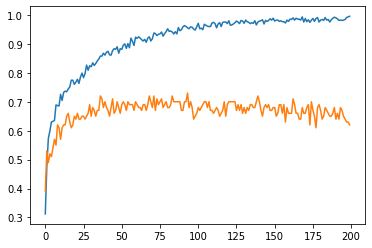

In [ ]:
history = model_create_learn(bn=3)

modelsTrainAccuracy.append(history.history["accuracy"][-1])
modelsTestAccuracy.append(history.history["val_accuracy"][-1])

del history

## Функция активации: relu (Э. 6)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
45/45 [==============================] - 1s 6ms/step - loss: 2.1654 - accuracy: 0.2478 - val_loss: 2.0519 - val_accuracy: 0.3400
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 1.9059 - accuracy: 0.3800 - val_loss: 1.8356 - val_accuracy: 0.3600
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 1.6822 - accuracy: 0.4189 - val_loss: 1.6570 - val_accuracy: 0.3700
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 1.5120 - accuracy: 0.4778 - val_loss: 1.5291 - val_accuracy: 0.4000
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 1.3904 - accuracy: 0.5189 - val_loss: 1.4397 - val_accuracy: 0.4300
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 1.2991 - accuracy: 0.5656 - val_loss: 1.3848 - val_accuracy: 0.4900
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 1.2266 - accuracy: 0.5878 - val_loss: 1.3435 - val_accuracy: 0.4600
Epoch 8/200
4

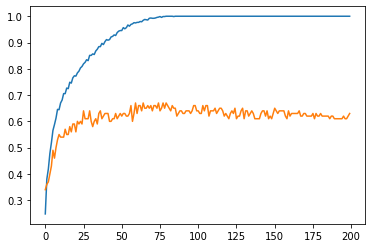

In [ ]:
history = model_create_learn(activ="relu")

modelsTrainAccuracy.append(history.history["accuracy"][-1])
modelsTestAccuracy.append(history.history["val_accuracy"][-1])

del history

## Функции активации: elu (Э. 7)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
45/45 [==============================] - 1s 6ms/step - loss: 1.8340 - accuracy: 0.3500 - val_loss: 1.6306 - val_accuracy: 0.3900
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 1.4978 - accuracy: 0.4700 - val_loss: 1.4917 - val_accuracy: 0.3700
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 1.3516 - accuracy: 0.5211 - val_loss: 1.4037 - val_accuracy: 0.4300
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 1.2563 - accuracy: 0.5722 - val_loss: 1.3491 - val_accuracy: 0.4800
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 1.1803 - accuracy: 0.6044 - val_loss: 1.3331 - val_accuracy: 0.4900
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 1.1213 - accuracy: 0.6222 - val_loss: 1.2922 - val_accuracy: 0.5100
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 1.0694 - accuracy: 0.6533 - val_loss: 1.2723 - val_accuracy: 0.4800
Epoch 8/200
4

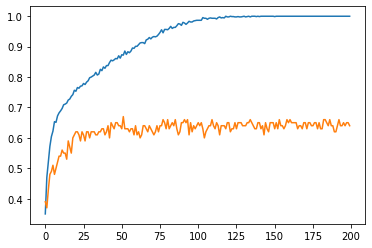

In [ ]:
history = model_create_learn(activ="elu")

modelsTrainAccuracy.append(history.history["accuracy"][-1])
modelsTestAccuracy.append(history.history["val_accuracy"][-1])

del history

## Функции активации: linear (Э. 8)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
45/45 [==============================] - 1s 5ms/step - loss: 1.8877 - accuracy: 0.3144 - val_loss: 1.6610 - val_accuracy: 0.3400
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 1.4549 - accuracy: 0.4767 - val_loss: 1.4886 - val_accuracy: 0.4100
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 1.3115 - accuracy: 0.5611 - val_loss: 1.4305 - val_accuracy: 0.4700
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 1.2236 - accuracy: 0.5956 - val_loss: 1.3762 - val_accuracy: 0.5000
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 1.1616 - accuracy: 0.6222 - val_loss: 1.3615 - val_accuracy: 0.5300
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 1.1104 - accuracy: 0.6389 - val_loss: 1.3201 - val_accuracy: 0.5500
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 1.0749 - accuracy: 0.6456 - val_loss: 1.3119 - val_accuracy: 0.5400
Epoch 8/200
4

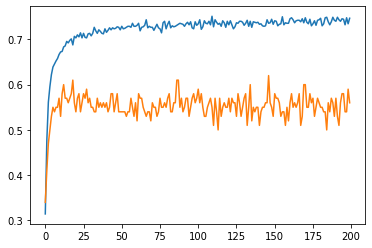

In [ ]:
history = model_create_learn(activ="linear")

modelsTrainAccuracy.append(history.history["accuracy"][-1])
modelsTestAccuracy.append(history.history["val_accuracy"][-1])

del history

## batch_size = 5 (Э. 9)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
180/180 [==============================] - 1s 3ms/step - loss: 1.7360 - accuracy: 0.3578 - val_loss: 1.4970 - val_accuracy: 0.4300
Epoch 2/200
180/180 [==============================] - 0s 2ms/step - loss: 1.3572 - accuracy: 0.5244 - val_loss: 1.3612 - val_accuracy: 0.4900
Epoch 3/200
180/180 [==============================] - 0s 2ms/step - loss: 1.1944 - accuracy: 0.6100 - val_loss: 1.3229 - val_accuracy: 0.4800
Epoch 4/200
180/180 [==============================] - 0s 2ms/step - loss: 1.0977 - accuracy: 0.6300 - val_loss: 1.2697 - val_accuracy: 0.5000
Epoch 5/200
180/180 [==============================] - 0s 2ms/step - loss: 1.0223 - accuracy: 0.6556 - val_loss: 1.2399 - val_accuracy: 0.5400
Epoch 6/200
180/180 [==============================] - 0s 2ms/step - loss: 0.9635 - accuracy: 0.6800 - val_loss: 1.2145 - val_accuracy: 0.5300
Epoch 7/200
180/180 [==============================] - 0s 2ms/step - loss: 0.9159 - accuracy: 0.6922 - val_loss: 1.1964 - val_accuracy: 0.5500

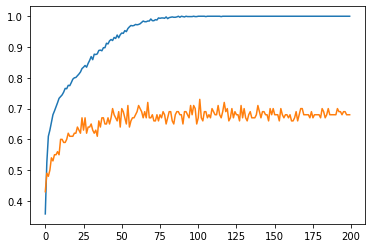

In [ ]:
history = model_create_learn(batch=5)

modelsTrainAccuracy.append(history.history["accuracy"][-1])
modelsTestAccuracy.append(history.history["val_accuracy"][-1])

del history

## batch_size = 40 (Э. 10)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
23/23 [==============================] - 1s 10ms/step - loss: 2.0107 - accuracy: 0.2956 - val_loss: 1.8427 - val_accuracy: 0.3200
Epoch 2/200
23/23 [==============================] - 0s 3ms/step - loss: 1.6523 - accuracy: 0.3878 - val_loss: 1.6613 - val_accuracy: 0.3200
Epoch 3/200
23/23 [==============================] - 0s 4ms/step - loss: 1.4915 - accuracy: 0.4644 - val_loss: 1.5620 - val_accuracy: 0.3400
Epoch 4/200
23/23 [==============================] - 0s 3ms/step - loss: 1.3823 - accuracy: 0.5000 - val_loss: 1.4777 - val_accuracy: 0.4400
Epoch 5/200
23/23 [==============================] - 0s 4ms/step - loss: 1.3019 - accuracy: 0.5478 - val_loss: 1.4396 - val_accuracy: 0.3900
Epoch 6/200
23/23 [==============================] - 0s 3ms/step - loss: 1.2351 - accuracy: 0.5733 - val_loss: 1.3952 - val_accuracy: 0.4400
Epoch 7/200
23/23 [==============================] - 0s 4ms/step - loss: 1.1824 - accuracy: 0.6078 - val_loss: 1.3625 - val_accuracy: 0.5000
Epoch 8/200


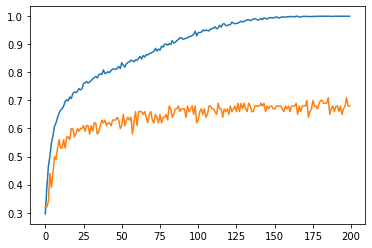

In [ ]:
history = model_create_learn(batch=40)

modelsTrainAccuracy.append(history.history["accuracy"][-1])
modelsTestAccuracy.append(history.history["val_accuracy"][-1])

del history

## batch_size = 80 (Э. 11)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
12/12 [==============================] - 1s 19ms/step - loss: 2.0166 - accuracy: 0.2967 - val_loss: 1.8280 - val_accuracy: 0.3100
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 1.6989 - accuracy: 0.4078 - val_loss: 1.6861 - val_accuracy: 0.3700
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 1.5677 - accuracy: 0.4556 - val_loss: 1.6141 - val_accuracy: 0.3500
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 1.4757 - accuracy: 0.4789 - val_loss: 1.5489 - val_accuracy: 0.3700
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 1.4037 - accuracy: 0.5289 - val_loss: 1.5119 - val_accuracy: 0.3800
Epoch 6/200
12/12 [==============================] - 0s 7ms/step - loss: 1.3428 - accuracy: 0.5422 - val_loss: 1.4695 - val_accuracy: 0.4300
Epoch 7/200
12/12 [==============================] - 0s 7ms/step - loss: 1.2932 - accuracy: 0.5689 - val_loss: 1.4451 - val_accuracy: 0.4600
Epoch 8/200


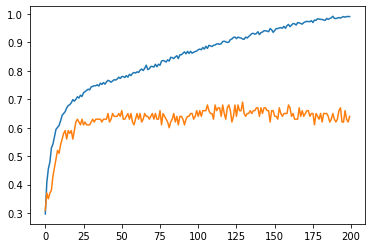

In [ ]:
history = model_create_learn(batch=80)

modelsTrainAccuracy.append(history.history["accuracy"][-1])
modelsTestAccuracy.append(history.history["val_accuracy"][-1])

del history

# Подведение итогов

In [ ]:
names = ["Полносвязная модель", "Простая модель:", "Сложная модель:",
         "Модель со слоем Dropout", "Модель со слоем BatchNormalization", "Функция активации: relu", "Функции активации: elu",
         "Функции активации: linear", "batch_size = 5", "batch_size = 40", "batch_size = 80"]

inds = [f"Э. {jj}" for jj in range(1, 12)]

df = pd.DataFrame({
    "Название": names,
    "Точность на обучающей выборке": modelsTrainAccuracy,
    "Точность на тестовой выборке": modelsTestAccuracy,
}, index=inds)
df.index.name = "Номер эксперимента"
print(df)

                                              Название  ...  Точность н
Номер эксперимента                                      ...            
Э. 1                               Полносвязная модель  ...        0.64
Э. 2                                   Простая модель:  ...        0.61
Э. 3                                   Сложная модель:  ...        0.62
Э. 4                           Модель со слоем Dropout  ...        0.68
Э. 5                Модель со слоем BatchNormalization  ...        0.62
Э. 6                           Функция активации: relu  ...        0.63
Э. 7                            Функции активации: elu  ...        0.64
Э. 8                         Функции активации: linear  ...        0.56
Э. 9                                    batch_size = 5  ...        0.68
Э. 10                                  batch_size = 40  ...        0.68
Э. 11                                  batch_size = 80  ...        0.64

[11 rows x 3 columns]


## Вывод

Из проведенных экспериментов видно, что лучше всего работают модели, созданные со слоем Dropout, с параметром batch_size = 5 или с параметром batch_size = 40
Самый худший результат показала модель с функцией активации linear
Среднее время выполнения моделей: 3-4мс на шаг, но при повышении batch_size до 80, время вырастает в 2 раза. 
Если смотреть на тенденцию изменения качества модели при изменении параметра batch_size, то нельзя четко сказать, от чего зависит точность нейронной сети, так как при разных значениях, один и тот же показатель, кроме последнего эксперимента
Модель показала, что для таких задач лучше всего использовать функцию активации elu
А вот разница между сложной нейронной сетью из 6 слоев и простой - из 1 всего 1%, однако в первом случае возможно переобучение, т. к. точность на обучающей выборке достигла 100%
